# Importing necessary libraries

In [ ]:
import numpy as np
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import os
import PIL
import cv2

# Mounting access to my google drive for connecting to dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load training data

In [ ]:
train_data = r"/content/drive/MyDrive/Split_smol/train"

# Data Pre-processing

In [ ]:
encoding = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma': 5,
    'Squamous cell carcinoma': 6,
    'Tinea Ringworm Candidiasis': 7,
    'Vascular lesion': 8
}

NUM_CLASSES = 9

def encoder(val):
    return encoding[val]

In [ ]:
from PIL import Image
import keras

dataset = []

for category in os.listdir(train_data):
    category_path = os.path.join(train_data, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path).convert('RGB')
        image = np.asarray(image)
        image = cv2.resize(image, (240, 240))
        image = image / 255.
        dataset.append([image, category])

data, labels = zip(*dataset)
temp = map(encoder, labels)
temp = list(temp)

# Categorically encoding the labels
labels = keras.utils.to_categorical(temp)

# Training the DenseNet model

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import layers

densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

def build_densenet():
    model = tf.keras.Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.75))  # 0.2
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),  # 0.00005
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_densenet()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 9)                 9225      
                                                                 
Total params: 7046729 (26.88 MB)
Trainable params: 6963081 (26.56 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [ ]:
densenet_model = model.fit(np.array(data), np.array(labels), epochs = 10, shuffle = True, validation_split = 0.2) # 5, 0.2 # 5, 0.0 gave best

Epoch 1/10
18/18 [==============================] - 96s 1s/step - loss: 0.9076 - accuracy: 0.1095 - val_loss: 0.6062 - val_accuracy: 0.4857
Epoch 2/10
18/18 [==============================] - 7s 399ms/step - loss: 0.7508 - accuracy: 0.1993 - val_loss: 0.5569 - val_accuracy: 0.4214
Epoch 3/10
18/18 [==============================] - 7s 402ms/step - loss: 0.6177 - accuracy: 0.3196 - val_loss: 0.5158 - val_accuracy: 0.3929
Epoch 4/10
18/18 [==============================] - 7s 409ms/step - loss: 0.4905 - accuracy: 0.4129 - val_loss: 0.4766 - val_accuracy: 0.3643
Epoch 5/10
18/18 [==============================] - 7s 405ms/step - loss: 0.4194 - accuracy: 0.4865 - val_loss: 0.4374 - val_accuracy: 0.3643
Epoch 6/10
18/18 [==============================] - 7s 400ms/step - loss: 0.3778 - accuracy: 0.5224 - val_loss: 0.4121 - val_accuracy: 0.2643
Epoch 7/10
18/18 [==============================] - 7s 397ms/step - loss: 0.3173 - accuracy: 0.5996 - val_loss: 0.3992 - val_accuracy: 0.2429
Epoch 8/

# Accuracy and Loss plot

In [ ]:
import seaborn as sns
from matplotlib import pyplot

def plot_acc(densenet_model):
    sns.set()

    fig = pyplot.figure(0, (12, 4))

    ax = pyplot.subplot(1, 2, 1)
    sns.lineplot(x=densenet_model.epoch, y=densenet_model.densenet_model['accuracy'], label='accuracy')
    sns.lineplot(x=densenet_model.epoch, y=densenet_model.densenet_model['loss'], label='loss')
    pyplot.title('Accuracy And Loss')
    pyplot.tight_layout()
    pyplot.show()

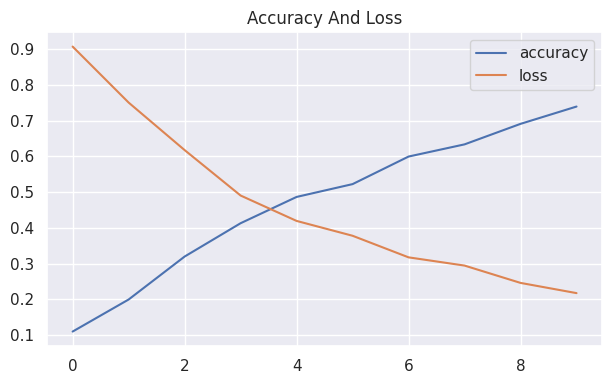

In [ ]:
plot_acc(densenet_model)

# Saving the model

In [ ]:
# Save the model for later use
model.save("Densenet.h5")

# Load test data

### Processing the dataset similar to what we did with training data

In [ ]:
test_data = r"/content/drive/MyDrive/Split_smol/val"

In [ ]:
from PIL import Image
import keras

dataset_testing = []

for category in os.listdir(test_data):
    category_path = os.path.join(test_data, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path).convert('RGB')
        image = np.asarray(image)
        image = cv2.resize(image, (240, 240))
        image = image / 255.
        dataset_testing.append([image, category])

testing_data, testing_labels = zip(*dataset_testing)
testing_temp = map(encoder, testing_labels)
testing_temp = list(testing_temp)

# Categorical encoding
testing_labels = keras.utils.to_categorical(testing_temp)

# Run predictions and evaluate the model

In [ ]:
model.evaluate(np.array(testing_data), np.array(testing_labels))

6/6 [==============================] - 4s 817ms/step - loss: 0.2701 - accuracy: 0.6133


[0.27006497979164124, 0.6132596731185913]

# Confusion Matrix

In [ ]:
!pip install scikit-plot

In [ ]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot

# Make predictions
def make_preds(model):
    label_preds = model.predict(np.array(testing_data))

    def one_hot_highest(arr):
        for row in arr:
            max_val = max(row)
            for i in range(len(row)):
                if row[i] == max_val:
                    row[i] = 1
                else:
                    row[i] = 0
        return arr

    arr=one_hot_highest(label_preds) #one hot
    arr2= one_hot_highest(testing_labels)

    labelenc=[]
    for i in range (0, len(arr)):
        flag=0
        for j in range (0,9):
            if arr[i][j]==1:
                labelenc.append(j)
                flag=1
    labelenctest=[]
    for i in range (0, len(arr2)):
        for j in range (0,9):
            if arr2[i][j]==1:
                labelenctest.append(j)

    scikitplot.metrics.plot_confusion_matrix(labelenctest,labelenc)

6/6 [==============================] - 4s 106ms/step


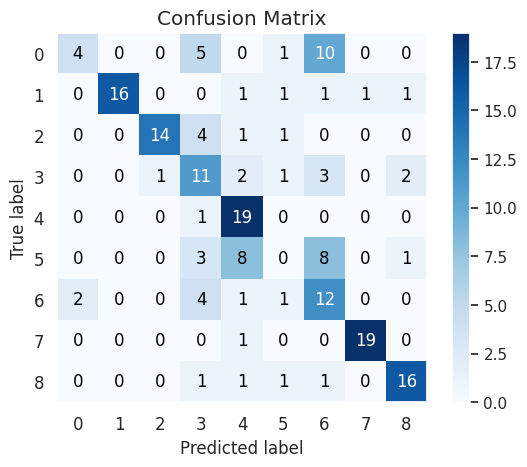

In [ ]:
make_preds(model)

# Precision, Recall and F1 statistics

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Separate images and labels
X_test = np.array([data[0] for data in dataset_testing])
y_test = np.array([data[1] for data in dataset_testing])

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
label_to_index = {class_name: index for index, class_name in enumerate(set(y_test))}
y_test_numeric = np.array([label_to_index[label] for label in y_test])
y_pred_numeric = np.argmax(y_pred_prob, axis=1)
# Compute precision, recall, F1-score, and support for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_numeric, y_pred_numeric, average=None)

# Calculate average precision and recall
average_precision = sum(precision) / len(precision)
average_recall = sum(recall) / len(recall)
average_f1_score = sum(f1_score) / len(f1_score)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1-score:", average_f1_score)


6/6 [==============================] - 1s 95ms/step
Average Precision: 0.3266235229724074
Average Recall: 0.3386243386243386
Average F1-score: 0.30469354278878086


# Plot ROC curve

6/6 [==============================] - 1s 92ms/step


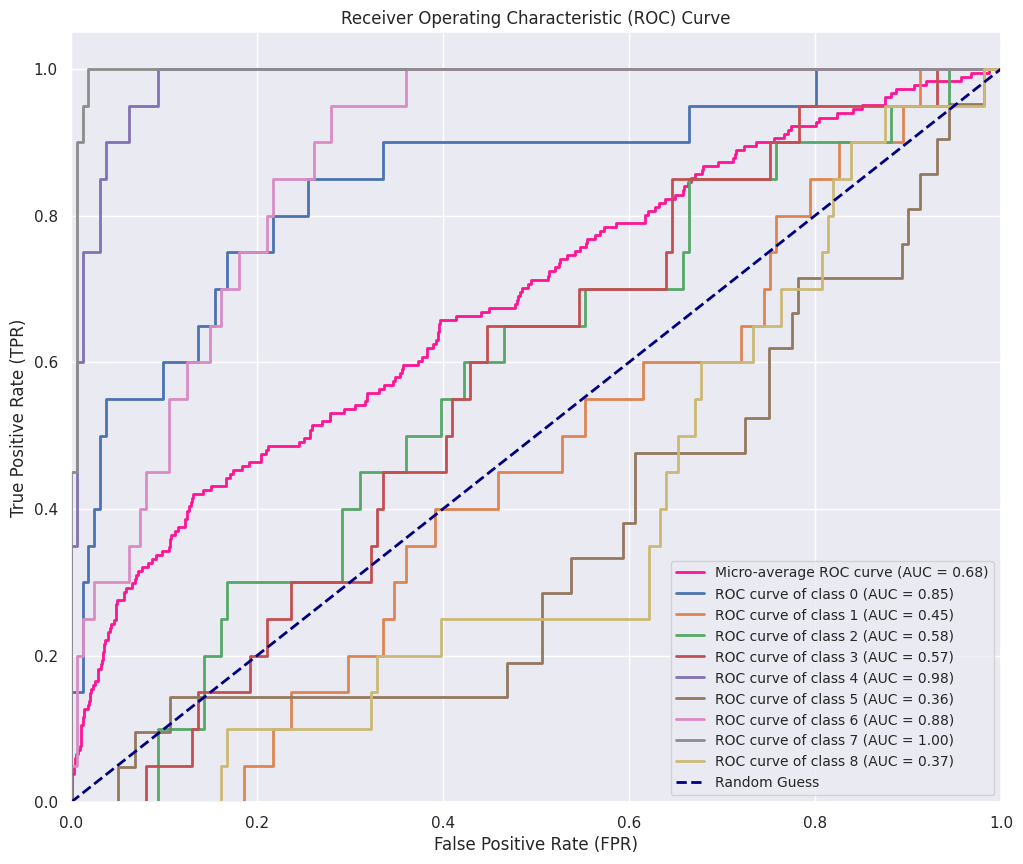

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Binarize the labels for multiclass classification
y_test_binarized = label_binarize(y_test_numeric, classes=np.unique(y_test_numeric))

# Compute predicted probabilities for each class
y_score = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the ROC curve for each class
plt.figure(figsize=(12,10))
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, label='Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro)
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', fontsize='small')
plt.show()